# Прогнозирование температуры звезды


Пришла задача от обсерватории «Небо на ладони»: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами:

* Закон смещения Вина.
* Закон Стефана-Больцмана.
* Спектральный анализ.

Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.

В базе обсерватории есть характеристики уже изученных 240 звёзд.

**Характеристики**

*Относительная светимость L/Lo* — светимость звезды относительно Солнца.

*Относительный радиус R/Ro* — радиус звезды относительно радиуса Солнца.

*Абсолютная звёздная величина Mv*  — физическая величина, характеризующая блеск звезды.

*Звёздный цвет (white, red, blue, yellow, yellow-orange и др.)* — цвет звезды, который определяют на основе спектрального анализа.

*Тип звезды* 

Коричневый карлик	0, Красный карлик	1, Белый карлик	2, Звёзды главной последовательности	3, Сверхгигант	4, Гипергигант	5


*Абсолютная температура T(K)* — температура на поверхности звезды в Кельвинах.



💡 Справочная информация:
 Светимость Солнца (англ. Average Luminosity of Sun)
 
L0 = 3.828 ⋅ (10)^26 Вт

 Радиус Солнца (англ. Average Radius of Sun) 
 
R0 = 6.9551 ⋅ (10)^8 м



## Установка библиотек

In [1]:
!pip install pandas-profiling -U

In [2]:
!pip install -U scikit-learn

## Загрузка данных

In [3]:
#импортируем нужные библиотеки для работы
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ydata_profiling
import os
import torch
import torch.nn as nn
from tqdm import tqdm
import warnings


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.compose import ColumnTransformer

from sklearn.metrics import mean_squared_error




random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

In [4]:
#прочитаем данные 
pth1 = '/datasets/6_class.csv'

data = pd.read_csv(pth1)

## Анализ данных 

In [5]:
# создаём отчёт
profile = data.profile_report(title='Pandas Profiling Report', progress_bar=False)
# смотрим отчёт в HTML формате
profile

### Выводы по анализу данных

1) Пропусков и дубликатов нет, данные чистые. Данные содержат 1 категориальный признак и 5 количественных.

2) Наблюдаются высокие корреляции между признаками, особенно между типом звезды и остальными признаками. Для астрономических характеристик это нормально, так как тип звезды как раз определяется данными характеристиками. Кроме того, смотря графики распределения данных между типом звезды и другими показателями, даже визуально можно выделить группы звезд. Можно предположить, что наиболее влиятельными признаками могут быть тип звезды и её температура.

3) *Temperature (K)* имеетнеравномерную гистограмму, потому что некоторое количество звезд имеет экстремально высокую температуру. Для астрономии это также нормально, это не выбросы, а отдельный класс звёзд.Подобная картина наблюдается для *Luminosity(L/Lo)* и *Radius(R/Ro)*.

*Absolute magnitude(Mv)* имеет неизвестное распределение с некоторыми провалами, но похоже на реальное.

В *Star color* самый частый цвет красный. С категориях есть дубликатные признаки, с которыми необходимо поработать.

## Предобработка



### Поработаем с категориями цветов, а также категоризиуем этот признак

In [6]:
data['Star color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

In [7]:
# функция для замены цвета
def get_color(value):
    if value == 'Blue-white':
        return 'Blue White'
    if value == 'Blue-White':
        return 'Blue White'    
    if value == 'Blue white':
        return 'Blue White'
    if value == 'Blue white ':
        return 'Blue White'
    if value == 'white':
        return 'White'
    if value == 'Blue ':
        return 'Blue'
    if value == 'yellowish':
        return 'Yellowish'
    if value == 'yellow-white':
        return 'White-Yellow'
    else: value == value 
    return value 
    

data['Star color'] = data['Star color'].apply(get_color)

In [8]:
#проверим полные дубликаты
print(data.duplicated().sum())

0


### Подготовим обучающую и тестовую выборки. А также масштабируем количественные данные

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=['Temperature (K)']), data['Temperature (K)'],
    #     stratify=data['Star color'],
    test_size=0.25, 
    shuffle=True,
    random_state=42)


In [10]:
col_num = X_test['Unnamed: 0']

#удалим столбец с индексом, он будет мешать 
X_train.drop(columns=X_train.columns[0], axis= 1 , inplace= True )
X_test.drop(columns=X_test.columns[0], axis= 1 , inplace= True )


In [11]:
numeric = ['Luminosity(L/Lo)','Radius(R/Ro)','Absolute magnitude(Mv)']
categorical = ['Star color', 'Star type']

col_transformer = ColumnTransformer(
                            transformers=[
                                ('scaler', StandardScaler(), numeric),
                                ('ohe', OneHotEncoder(sparse=False, drop='first',handle_unknown = 'ignore'), categorical)],
                                    remainder="passthrough"
                                      )

X_train = col_transformer.fit_transform(X_train)
X_test = col_transformer.transform(X_test)
    

print(X_train.shape, X_test.shape)

(180, 17) (60, 17)


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [12]:
#переведём данные в формат тензоров
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test.values)

## Построение базовой нейронной сети

### 0 вариант

Самый простой, пробный вариант

In [13]:
# Гиперпараметры обучения:
n_in_neurons = X_train.shape[1] 
n_hidden_neurons_1 = 128
n_hidden_neurons_2 = 256
n_out_neurons = 1

num_epochs = 20000 # количество эпох
batch_size = 1000 # количество батчей
learning_rate = 0.001



In [14]:
class StarNet(nn.Module): 
    '''
    Класс по созданию нейронной сети
    '''
    def __init__(self, n_features, n, n1):
        super().__init__()
        self.fc1 = torch.nn.Linear(n_features, n)
        self.fc2 = nn.Linear(n, n1)
        self.fc3 = nn.Linear(n1, 1)
        self.relu1 = nn.LeakyReLU()
        self.relu2 = nn.LeakyReLU()
        self.relu3 = nn.LeakyReLU(negative_slope=0.7)    
        
    def forward(self, batch):
        batch = self.fc1(batch)
        batch = self.relu1(batch)
        batch = self.fc2(batch)
        batch = self.relu2(batch)
        batch = self.fc3(batch)    
        
        
        return self.relu3(batch)

In [15]:
# Объявим функцию learn_net
def learn_net(num_epochs, X_train,y_train,X_test,y_test ):
    """
    Функция обучения нс и выводом графика значений rmse от эпох для двух выборок.
    
    Параметры:
    num_epochs,
    X_train,
    y_train,
    X_test,
    y_test
    
    """
    
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3) # создаем Adam оптимизатор
 
    loss = nn.MSELoss(reduction='sum') 
 
    
    result_for_plot = []
    train_result_for_plot = []
    epoch_for_plot = []


    for epoch in range(num_epochs):
        optimizer.zero_grad()
 
        preds = net.forward(X_train).flatten()
 
        loss_value = loss(preds, y_train)
 
        loss_value.backward()
 
        optimizer.step()
 
        if epoch % 5000 == 0 or epoch == num_epochs - 1:
            net.eval()
            test_preds = net.forward(X_test)
            pred_temp = test_preds.detach().numpy()
            rmse = mean_squared_error(y_test, pred_temp, squared=False)
            result_for_plot.append(rmse)
        
            train_preds = net.forward(X_train)
            train_pred_temp = train_preds.detach().numpy()
            train_rmse = mean_squared_error(y_train, train_pred_temp, squared=False)
            train_result_for_plot.append(train_rmse)
        
        
            epoch_for_plot.append(epoch)
            print(rmse)
        
    plt.plot(epoch_for_plot, result_for_plot)
    plt.plot(epoch_for_plot, train_result_for_plot)
    plt.title('график зависимости rmse модели от эпох')
    plt.show()
    
    return pred_temp
        
            

14626.113
6405.2886
4602.5386
5438.322
5993.5894


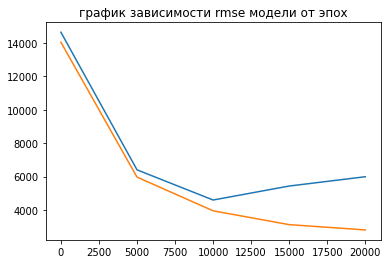

In [16]:
net = StarNet(n_in_neurons, n_hidden_neurons_1,  n_out_neurons)

#применим функцию обучения сети
pred_temp = learn_net(num_epochs, X_train,y_train,X_test,y_test )

### I вариант

Немного улучшенный вариант, изменен параметр flatten()

In [17]:
# Гиперпараметры обучения:
n_in_neurons = X_train.shape[1] 
n_hidden_neurons_1 = 32
n_hidden_neurons_2 = 64
n_hidden_neurons = 128
n_out_neurons = 1

num_epochs = 40_000 # количество эпох
batch_size = 1000 # количество батчей
learning_rate = 0.001

In [18]:
class Net(nn.Module): #ревьюера
    '''
    Класс по созданию нейронной сети
    '''
    def __init__(self, in_neurons, n_hidden_neurons, n_out_neurons):
        super(Net, self).__init__()  
        self.fc1= nn.Linear(in_neurons,n_hidden_neurons)
        self.fc2= nn.Linear(n_hidden_neurons,n_out_neurons)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten(start_dim=1)
    def forward(self,x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        return self.flatten(x)

14626.806
8403.328
6626.5215
5192.7324
4752.48
4725.479
5013.6396
5505.2173
6036.4775


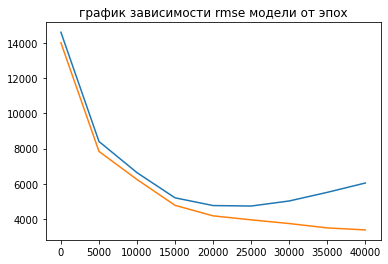

In [19]:
net = Net(n_in_neurons, n_hidden_neurons,  n_out_neurons)

#применим функцию обучения сети
pred_temp = learn_net(num_epochs, X_train,y_train,X_test,y_test )

### II вариант с инициализацией весов и добавлением ещё одного слоя

In [20]:
# Гиперпараметры обучения:
n_in_neurons = X_train.shape[1] 
n_hidden_neurons_1 = 32
n_hidden_neurons_2 = 64
n_hidden_neurons_3 = 128
n_hidden_neurons = 128
n_out_neurons = 1

num_epochs = 20_000 # количество эпох
batch_size = 1000 # количество батчей
learning_rate = 0.001

In [21]:
class Net(nn.Module): #ревьюера
    '''
    Класс по созданию нейронной сети
    '''
    def __init__(self, in_neurons, n_hidden_neurons_1,n_hidden_neurons_2,n_hidden_neurons_3, n_out_neurons):
        super(Net, self).__init__()  
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        
        self.fc4 = nn.Linear(n_hidden_neurons_3, n_out_neurons)
        
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten(start_dim=1)

        #инициализируем веса
        nn.init.uniform_(self.fc1.weight,  a=-2, b=2)
        nn.init.uniform_(self.fc1.bias,  a=-2, b=2)
        
        
        nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.fc2.bias, mean=0.5, std=0.7)
        
        nn.init.kaiming_uniform_(self.fc3.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.fc3.bias, mean=0.5, std=0.7)
        
        nn.init.kaiming_uniform_(self.fc4.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.fc4.bias, mean=0.5, std=0.7)
        
        
    def forward(self,x):
        x = self.fc1(x)
        x = self.relu(x)

        x = self.fc2(x)
        x = self.relu(x)

        x = self.fc3(x)
        x = self.relu(x)
        
        x = self.fc4(x)
        x = self.relu(x)
        
        return self.flatten(x)

14625.009
6534.208
7254.9995
9959.507
9279.669


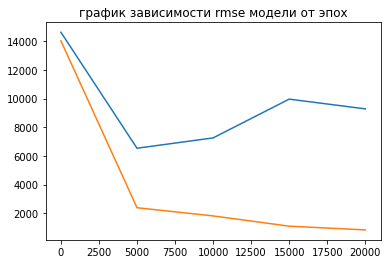

In [22]:
net = Net(n_in_neurons, n_hidden_neurons_1,n_hidden_neurons_2,n_hidden_neurons_3,  n_out_neurons)

#применим функцию обучения сети
pred_temp = learn_net(num_epochs, X_train,y_train,X_test,y_test )

### III вариант с увеличенным количеством слоёв без инициализации весов

In [23]:
# Гиперпараметры обучения:
in_neurons = X_train.shape[1] 
n_hidden_neurons_1 = 32
n_hidden_neurons_2 = 64
n_hidden_neurons_3 = 256
n_hidden_neurons_4 = 256
n_out_neurons = 1

num_epochs = 20_000 # количество эпох
batch_size = 1000 # количество батчей
learning_rate = 0.001

In [24]:
class Net(nn.Module): #ревьюера
    '''
    Класс по созданию нейронной сети
    '''
    def __init__(self, in_neurons, n_hidden_neurons_1,n_hidden_neurons_2,n_hidden_neurons_3,n_hidden_neurons_4, n_out_neurons):
        super(Net, self).__init__()  
        self.fc1= nn.Linear(in_neurons,n_hidden_neurons_1)
        self.fc2= nn.Linear(n_hidden_neurons_1,n_hidden_neurons_2)
        self.fc3= nn.Linear(n_hidden_neurons_2,n_hidden_neurons_3)
        self.fc4= nn.Linear(n_hidden_neurons_3,n_hidden_neurons_4)
        self.fc5= nn.Linear(n_hidden_neurons_4,n_out_neurons)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten(start_dim=1)
    def forward(self,x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
#         x = self.relu(x)
        return self.flatten(x)

14626.828
10065.378
11254.871
13022.898
13815.594


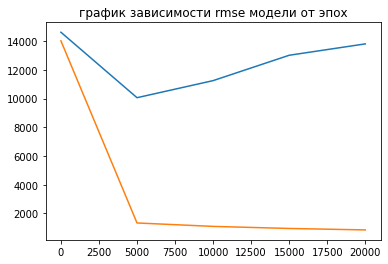

In [25]:
net = Net(in_neurons, n_hidden_neurons_1,n_hidden_neurons_2,n_hidden_neurons_3,n_hidden_neurons_4, n_out_neurons)

#применим функцию обучения сети
pred_temp = learn_net(num_epochs, X_train,y_train,X_test,y_test )

###  График «Факт — Прогноз»

По горизонтальной оси будут отложены условные номера звёзд, а по вертикальной — температура в Кельвинах.

In [26]:
#создание датафрейма для графика

preds = pd.DataFrame(pred_temp) 
y_test = pd.DataFrame(y_test)
col_num = pd.DataFrame(col_num)

col_num = col_num.sort_values(by='Unnamed: 0', ascending=True)
col_num.reset_index(drop= True , inplace= True )

df = pd.concat([col_num, preds, y_test], axis= 1 )
df.columns = ['col_num', 'preds', 'y_test']

df

,col_num,preds,y_test
0,6,13701.360352,16500.0
1,9,3050.167480,2637.0
2,10,3632.835693,4980.0
3,15,22216.105469,33421.0
4,16,34209.839844,11096.0
5,18,4335.395020,4287.0
6,19,11424.660156,27739.0
7,24,14640.758789,12010.0
8,25,3144.750488,2700.0
9,30,13822.334961,14520.0


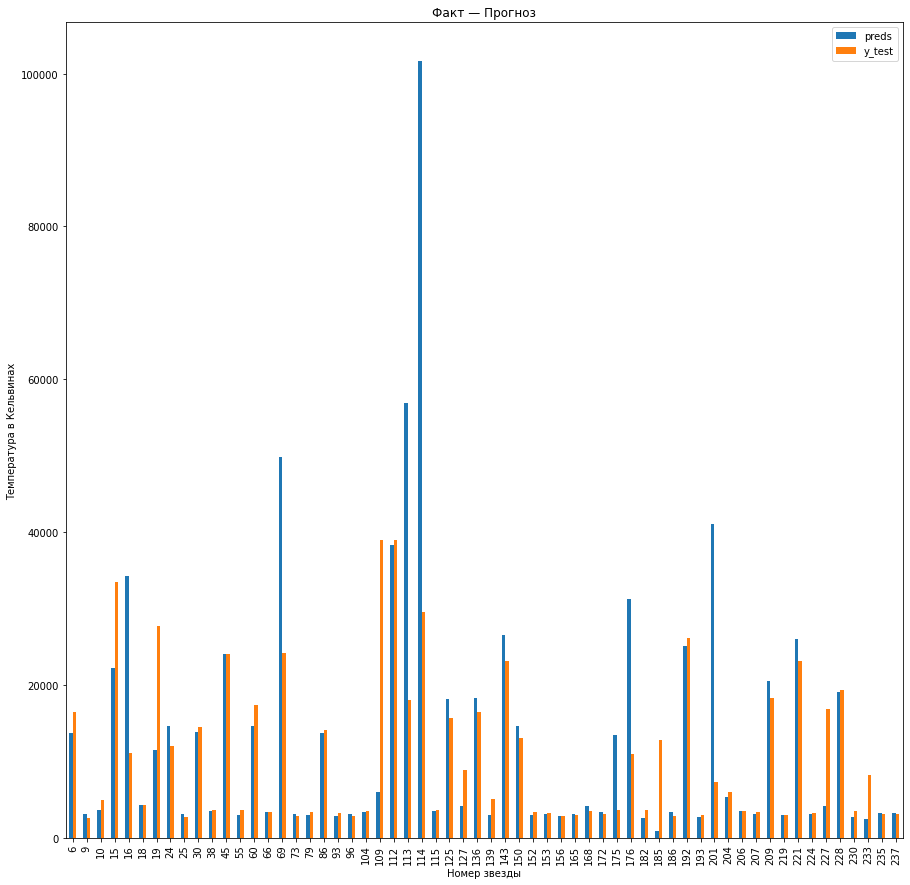

In [27]:

df[['col_num', 'preds', 'y_test']].plot(x='col_num', kind='bar', figsize = (15,15), title = 'Факт — Прогноз', xlabel = 'Номер звезды', ylabel = 'Температура в Кельвинах') 
plt.show()

## Улучшение нейронной сети

### 0 вариант с BatchNorm

In [28]:
# Гиперпараметры обучения:
n_in_neurons = X_train.shape[1] 
n_hidden_neurons_1 = 128
n_hidden_neurons_2 = 256
n_out_neurons = 1

num_epochs = 70000 # количество эпох
batch_size = 1000 # количество батчей
learning_rate = 0.001



In [29]:
class StarNet(nn.Module): 
    '''
    Класс по созданию нейронной сети
    '''
    def __init__(self, n_features, n, n1):
        super().__init__()
        self.fc1 = torch.nn.Linear(n_features, n)
        self.fc2 = nn.Linear(n, n1)
        self.fc3 = nn.Linear(n1, 1)
        self.relu1 = nn.LeakyReLU()
        self.relu2 = nn.LeakyReLU()
        self.relu3 = nn.LeakyReLU(negative_slope=0.7) 
        self.bn1 = nn.BatchNorm1d(n)
        self.bn2 = nn.BatchNorm1d(n1)
        
    def forward(self, batch):
        batch = self.fc1(batch)
        batch = self.bn1(batch)
        batch = self.relu1(batch)
        batch = self.fc2(batch)
        atch = self.bn2(batch)
        batch = self.relu2(batch)
        batch = self.fc3(batch)    
        
        
        return self.relu3(batch)

14627.202
4303.8447
5032.4443
6487.7964
7414.9346
8094.2944
8557.523
11046.059
12543.912
13938.938
15427.751
16431.752
17295.613
18087.479
18677.506


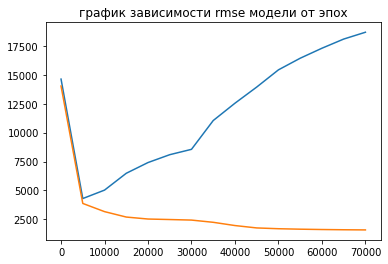

In [30]:
net = StarNet(n_in_neurons, n_hidden_neurons_1,  n_out_neurons)
 
#применим функцию обучения сети
pred_temp = learn_net(num_epochs, X_train,y_train,X_test,y_test )

Добавление BatchNorm дал даже более плохие результаты, чем без него

### II вариант с BatchNorm

In [31]:
# Гиперпараметры обучения:
n_in_neurons = X_train.shape[1] 
n_hidden_neurons_1 = 32
n_hidden_neurons_2 = 64
n_hidden_neurons_3 = 128
n_hidden_neurons = 128
n_out_neurons = 1

num_epochs = 40_000 # количество эпох
batch_size = 1000 # количество батчей
learning_rate = 0.001

In [32]:
class Net(nn.Module): #ревьюера
    '''
    Класс по созданию нейронной сети
    '''
    def __init__(self, in_neurons, n_hidden_neurons_1,n_hidden_neurons_2,n_hidden_neurons_3, n_oout_neurons):
        super(Net, self).__init__()  
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        
        self.fc4 = nn.Linear(n_hidden_neurons_3, n_out_neurons)
        
        self.relu = nn.ReLU()
        
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
        self.bn3 = nn.BatchNorm1d(n_hidden_neurons_3)
        
        self.flatten = nn.Flatten(start_dim=1)

        #инициализируем веса
        nn.init.uniform_(self.fc1.weight,  a=-2, b=2)
        nn.init.uniform_(self.fc1.bias,  a=-2, b=2)
        
        
        nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.fc2.bias, mean=0.5, std=0.7)
        
        nn.init.kaiming_uniform_(self.fc3.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.fc3.bias, mean=0.5, std=0.7)
        
        nn.init.kaiming_uniform_(self.fc4.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.fc4.bias, mean=0.5, std=0.7)
        
        
    def forward(self,x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        
        x = self.fc4(x)
        x = self.relu(x)
        
        return self.flatten(x)

14626.85
8692.883
9055.309
10826.228
12585.9795
13893.449
14613.341
15280.487
15776.671


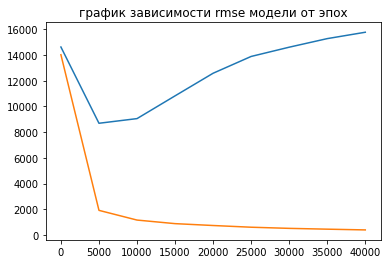

In [33]:

net = Net(n_in_neurons, n_hidden_neurons_1,n_hidden_neurons_2,n_hidden_neurons_3,  n_out_neurons)
 
#применим функцию обучения сети
pred_temp = learn_net(num_epochs, X_train,y_train,X_test,y_test )

### Попробуем применить dropout к 0 варианту

In [34]:
# Гиперпараметры обучения:
n_in_neurons = X_train.shape[1] 
n_hidden_neurons_1 = 128
n_hidden_neurons_2 = 256
n_out_neurons = 1

num_epochs = 70000 # количество эпох
batch_size = 1000 # количество батчей
learning_rate = 0.001



In [35]:
class StarNet(nn.Module): 
    '''
    Класс по созданию нейронной сети
    '''
    def __init__(self, n_features, n, n1):
        super().__init__()
        self.fc1 = torch.nn.Linear(n_features, n)
        self.fc2 = nn.Linear(n, n1)
        self.fc3 = nn.Linear(n1, 1)
        
        self.dp1 = nn.Dropout(p=0.2)
        self.dp2 = nn.Dropout(p=0.6)
        
        self.relu1 = nn.LeakyReLU()
        self.relu2 = nn.LeakyReLU()
        self.relu3 = nn.LeakyReLU(negative_slope=0.7)    
        
    def forward(self, batch):
        batch = self.fc1(batch)
        batch = self.relu1(batch)
        batch = self.dp1(batch)
        batch = self.fc2(batch)
        batch = self.relu2(batch)
        batch = self.dp2(batch)
        batch = self.fc3(batch)    
        
        
        return self.relu3(batch)

14626.936
13254.58
9798.591
7750.0747
7105.1055
6395.907
5408.8345
4845.829
4915.81
4995.822
5199.835
5388.714
5623.337
5748.7964
5731.7837


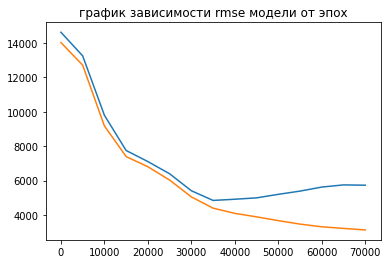

In [36]:
net = StarNet(n_in_neurons, n_hidden_neurons_1,  n_out_neurons)
 
#применим функцию обучения сети
pred_temp = learn_net(num_epochs, X_train,y_train,X_test,y_test )

### Попробуем применить dropout к 0 варианту с BatchNorm

In [37]:
# Гиперпараметры обучения:
n_in_neurons = X_train.shape[1] 
n_hidden_neurons_1 = 128
n_hidden_neurons_2 = 256
n_out_neurons = 1

num_epochs = 70000 # количество эпох
batch_size = 1000 # количество батчей
learning_rate = 0.001



In [38]:
class StarNet(nn.Module): 
    '''
    Класс по созданию нейронной сети
    '''
    def __init__(self, n_features, n, n1):
        super().__init__()
        self.fc1 = torch.nn.Linear(n_features, n)
        self.fc2 = nn.Linear(n, n1)
        self.fc3 = nn.Linear(n1, 1)
        self.relu1 = nn.LeakyReLU()
        self.relu2 = nn.LeakyReLU()
        self.relu3 = nn.LeakyReLU(negative_slope=0.7) 
        self.bn1 = nn.BatchNorm1d(n)
        self.bn2 = nn.BatchNorm1d(n1)
        
        self.dp1 = nn.Dropout(p=0.2)
        self.dp2 = nn.Dropout(p=0.6)
        
    def forward(self, batch):
        batch = self.fc1(batch)
        batch = self.bn1(batch)
        batch = self.relu1(batch)
        batch = self.dp1(batch)
        batch = self.fc2(batch)
        batch = self.bn2(batch)
        batch = self.relu2(batch)
        batch = self.dp2(batch)
        batch = self.fc3(batch)    
        
        
        return self.relu3(batch)

14626.117
6907.0464
4475.4976
4038.8186
4352.535
8868.396
31124.203
21839.174
127002.12
230109.12
305600.7
322457.22
334114.44
344847.84
357391.38


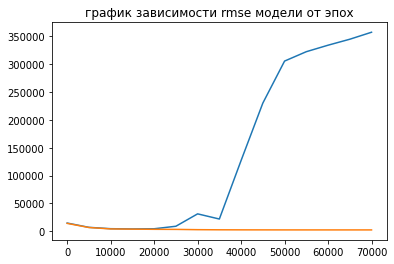

In [39]:
net = StarNet(n_in_neurons, n_hidden_neurons_1,  n_out_neurons)
 
#применим функцию обучения сети
pred_temp = learn_net(num_epochs, X_train,y_train,X_test,y_test )

###  Попробуем применить dropout к II варианту с BatchNorm

In [40]:
# Гиперпараметры обучения:
n_in_neurons = X_train.shape[1] 
n_hidden_neurons_1 = 32
n_hidden_neurons_2 = 64
n_hidden_neurons_3 = 128
n_hidden_neurons = 128
n_out_neurons = 1

num_epochs = 40_000 # количество эпох
batch_size = 1000 # количество батчей
learning_rate = 0.001

In [41]:
class Net(nn.Module): #ревьюера
    '''
    Класс по созданию нейронной сети
    '''
    def __init__(self, in_neurons, n_hidden_neurons_1,n_hidden_neurons_2,n_hidden_neurons_3, n_out_neurons):
        super(Net, self).__init__()  
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        
        self.fc4 = nn.Linear(n_hidden_neurons_3, n_out_neurons)
        
        self.relu = nn.ReLU()
        
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
        self.bn3 = nn.BatchNorm1d(n_hidden_neurons_3)
        
        self.dp1 = nn.Dropout(p=0.2)
        self.dp2 = nn.Dropout(p=0.6)
        self.dp3 = nn.Dropout(p=0.8)
        
        
        self.flatten = nn.Flatten(start_dim=1)

        #инициализируем веса
        nn.init.uniform_(self.fc1.weight,  a=-2, b=2)
        nn.init.uniform_(self.fc1.bias,  a=-2, b=2)
        
        
        nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.fc2.bias, mean=0.5, std=0.7)
        
        nn.init.kaiming_uniform_(self.fc3.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.fc3.bias, mean=0.5, std=0.7)
        
        nn.init.kaiming_uniform_(self.fc4.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.fc4.bias, mean=0.5, std=0.7)
        
        
    def forward(self,x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dp1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dp2(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dp3(x)
        
        x = self.fc4(x)
        x = self.relu(x)
        
        return self.flatten(x)

14626.5625
6644.269
7535.73
7616.9395
7521.681
7701.022
7808.268
8054.0825
8416.86


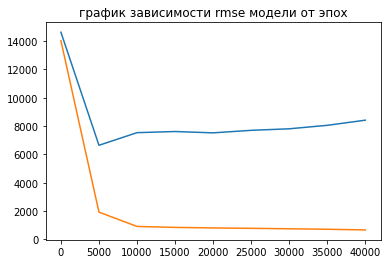

In [42]:
net = Net(n_in_neurons, n_hidden_neurons_1,n_hidden_neurons_2,n_hidden_neurons_3,  n_out_neurons)
 
#применим функцию обучения сети
pred_temp = learn_net(num_epochs, X_train,y_train,X_test,y_test )

###  Попробуем применить dropout к III варианту с BatchNorm

In [43]:
# Гиперпараметры обучения:
in_neurons = X_train.shape[1] 
n_hidden_neurons_1 = 32
n_hidden_neurons_2 = 64
n_hidden_neurons_3 = 256
n_hidden_neurons_4 = 256
n_out_neurons = 1

num_epochs = 40_000 # количество эпох
batch_size = 1000 # количество батчей
learning_rate = 0.001

In [46]:
class Net(nn.Module): #ревьюера
    '''
    Класс по созданию нейронной сети
    '''
    def __init__(self, in_neurons, n_hidden_neurons_1,n_hidden_neurons_2,n_hidden_neurons_3,n_hidden_neurons_4, n_out_neurons):
        super(Net, self).__init__()  
        self.fc1= nn.Linear(in_neurons,n_hidden_neurons_1)
        self.fc2= nn.Linear(n_hidden_neurons_1,n_hidden_neurons_2)
        self.fc3= nn.Linear(n_hidden_neurons_2,n_hidden_neurons_3)
        self.fc4= nn.Linear(n_hidden_neurons_3,n_hidden_neurons_4)
        self.fc5= nn.Linear(n_hidden_neurons_4,n_out_neurons)
        
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
        self.bn3 = nn.BatchNorm1d(n_hidden_neurons_3)
        self.bn4 = nn.BatchNorm1d(n_hidden_neurons_4)
        
        self.dp1 = nn.Dropout(p=0.2)
        self.dp2 = nn.Dropout(p=0.6)
        self.dp3 = nn.Dropout(p=0.8)
        self.dp4 = nn.Dropout(p=0.8)
        
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten(start_dim=1)
    def forward(self,x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dp1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dp2(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dp3(x)
        
        x = self.fc4(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dp3(x)
        
        x = self.fc5(x)
        #x = self.relu(x)
        return self.flatten(x)

14626.879
9039.393
10708.448
12138.866
13796.792
15629.428
16849.406
17749.111
17891.139


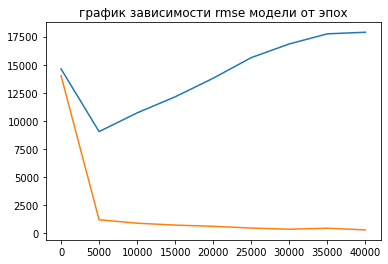

In [47]:
net = Net(in_neurons, n_hidden_neurons_1,n_hidden_neurons_2,n_hidden_neurons_3,n_hidden_neurons_4, n_out_neurons)

#применим функцию обучения сети
pred_temp = learn_net(num_epochs, X_train,y_train,X_test,y_test )

## Выводы

В данной работе были изучены данные обсерватории. Данные были практически идеальны и потребовали лишь небольшой коррекции признака "цвет". Далее данные были подготовлены к загрузке в нейронную сеть: были стандартизированы и закодированы. Далее было построено несколько вариантов нейронной сети с разными параметрами, после чего к этим вариантам были добавлены улучшения в виде BatchNorm и dropout. Лучших показателей достигнуто не было, поэтому стоит остановиться на более простых baseline моделях. Также ниже указаны улучшения проекта, благодаря которым вероятно выйдет достичь необходимых показателей выбранной метрики rmse

## Улучшения проекта

1) Использовать другие методы стандартизации и нормализации

2) Улучшить baseline: использовать больше слоёв, взять большее количество нейронов в слое, также более грамотно подобрать инициализацию весов, а также параметры улучшения нс